In [1]:
%matplotlib inline

from osgeo import gdal
import rasterio
from matplotlib import pyplot
import numpy
import pygeoprocessing

# Landsat 8 datasets from June 5, 2013
L8_RED_2013 = '../data/landsat/LC08_L1TP_042034_20130605_20170310_01_T1_B4_120x120.TIF'
L8_NIR_2013 = '../data/landsat/LC08_L1TP_042034_20130605_20170310_01_T1_B5_120x120.TIF'
L8_QA_2013 = '../data/landsat/LC08_L1TP_042034_20130605_20170310_01_T1_BQA_120x120.TIF'
L8_2013_FILES = [L8_RED_2013, L8_NIR_2013, L8_QA_2013]

# Landsat 8 datasets from June 29, 2016
L8_RED_2016 = '../data/landsat/LC08_L1TP_042034_20160629_20170222_01_T1_B4_120x120.TIF'
L8_NIR_2016 = '../data/landsat/LC08_L1TP_042034_20160629_20170222_01_T1_B5_120x120.TIF'
L8_QA_2016 = '../data/landsat/LC08_L1TP_042034_20160629_20170222_01_T1_BQA_120x120.TIF'
L8_2016_FILES = [L8_RED_2016, L8_NIR_2016, L8_QA_2016]

# We'll define an output nodata value.
NODATA = -9999

def plot(array):
    """Plot a numpy array with an NDVI colormap."""
    pyplot.imshow(array, cmap='RdYlGn')
    pyplot.colorbar()
    
    
def calc_ndvi(red, nir, qa):
    """Calculate NDVI from red and near-infrared landsat bands."""
    red = red.astype(numpy.float32)
    nir = nir.astype(numpy.float32)
    
    ndvi = (nir - red) / (nir + red)
    ndvi[qa==1] = NODATA
    return ndvi

# Let's calculate change in NDVI between 2013 and 2016!

In [14]:
import pygeoprocessing

aligned_files = ['al_red_2013.tif', 'al_nir_2013.tif', 'al_qa_2013.tif',
     'al_red_2016.tif', 'al_nir_2016.tif', 'al_qa_2016.tif']

pygeoprocessing.align_and_resize_raster_stack(
    L8_2013_FILES + L8_2016_FILES, # input files
    ['al_red_2013.tif', 'al_nir_2013.tif', 'al_qa_2013.tif',
     'al_red_2016.tif', 'al_nir_2016.tif', 'al_qa_2016.tif'],# order matters
    ['nearest']*6, # six element list (it's an abbreviated notation)
    (120,-120),
    'intersection'
)

def diff_ndvi(red_2013, nir_2013, qa_2013, red_2016, nir_2016, qa_2016):
    valid_pixels = (qa_2013 != 1) & (qa_2016 != 1)
    
    def calc_ndvi_new(red, nir):
        """Calculate NDVI from red and near-infrared landsat bands."""
        red = red[valid_pixels].astype(numpy.float32)
        nir = nir[valid_pixels].astype(numpy.float32)
    
    ndvi = (nir - red) / (nir + red)
    return ndvi
    
    ndvi_2013 = calc_ndvi_new(red_2013, nir_2013)
    ndvi_2016 = calc_ndvi_new(red_2016, nir_2016)
    
    output_ndvi = numpy.empty_like(red_2013, dtype=Numpy.float32)
    # need to create an empty framework because the logical indexing changed the rows/cols
    output_ndvi[:] = NODATA
    output_ndvi[valid_pixels] = ndvi_2013 - ndvi_2016
    
    return output_ndvi

pygeoprocessing.raster_calculator(
    [(filename, 1) for filename in aligned_files],
    diff_ndvi,
    'diff_ndvi.tif',
    gdal.GDT_Float32,
    NODATA
    
)

NameError: global name 'nir' is not defined

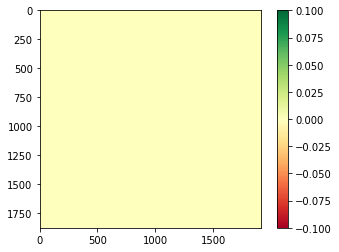

In [12]:
plot(gdal.Open('diff_ndvi.tif').ReadAsArray())